In [1]:
from itertools import islice
from typing import Callable

import matplotlib.pyplot as plt
import numpy as np
import torch as t
import torch.nn as nn
import torch.nn.functional as F
from beartype import beartype as typed
from beartype.door import die_if_unbearable as assert_type
from datasets import load_dataset
from einops import einops as ein
from jaxtyping import Bool, Float, Int
from torch import Tensor as TT
from transformers import AutoModelForCausalLM, AutoTokenizer

%load_ext autoreload
%autoreload 2

In [2]:
model = AutoModelForCausalLM.from_pretrained("Mlxa/brackets-nested")
tokenizer = AutoTokenizer.from_pretrained("Mlxa/brackets-nested")
dataset = load_dataset("Mlxa/nested", streaming=True)["train"]

In [3]:
from utils import sh, ls
from activation_analysis import (
    input_output_mapping,
    fit_linear,
    eval_module,
    Residual,
    PrefixMean,
)


@typed
def get_prompts(n: int, n_tokens: int) -> list[str]:
    return [
        " ".join(tokenizer.tokenize(elem["text"])[:n_tokens])
        for elem in islice(dataset, n)
    ]

In [4]:
layer = "transformer.h.1.attn.attention.k_proj"

In [ ]:
X_sae, Y_sae = input_output_mapping(
    model=model,
    tokenizer=tokenizer,
    prompts=get_prompts(100000, n_tokens=16),
    input_layer=layer,
    output_layer=layer,
)
# Y_sae -= X_sae

idx = t.randint(0, 16, size=(10 ** 5,))
X_selected = t.zeros((10 ** 5, 256))
Y_selected = t.zeros((10 ** 5, 256))
for i_prefix in range(len(idx)):
    X_selected[i_prefix] = X_sae[i_prefix, idx[i_prefix]]
    Y_selected[i_prefix] = Y_sae[i_prefix, idx[i_prefix]]

In [6]:
from sparse_autoencoders import fit_sae, SparseAutoEncoder

# activation_data = ein.rearrange(Y_sae, "prompts seq d -> (prompts seq) d")
activation_data = t.load("activations/L1_attn_k.pt")

In [7]:
sae = SparseAutoEncoder(256, 64)

In [10]:
others = [SparseAutoEncoder(256, d) for d in [32, 128]]

In [17]:
for other in others:
    fit_sae(other, activation_data, lr=1e-2, l1=0.5, alpha=1e-2, epochs=5)

100%|██████████| 5/5 [00:06<00:00,  1.38s/it,  loss=0.00, nonzero=15.47 / 128, nonorth=0.01]


In [22]:
fit_sae(sae, activation_data, lr=1e-3, l1=0.3, alpha=1e-3, epochs=20)

100%|██████████| 20/20 [00:23<00:00,  1.19s/it,  loss=0.00, nonzero=17.77 / 64, nonorth=0.01]


In [23]:
import plotly.express as px

for ae in [sae] + others:
    perm = t.argsort(-t.norm(ae.decoder, dim=1))
    covar = (ae.decoder[perm] @ ae.decoder[perm].T).clip(-2, 2)
    px.imshow(covar.detach()).show()

# pairs = []
# for i in range(covar.shape[0]):
#     for j in range(covar.shape[1]):
#         if i < j and covar[i, j] < -0.5:
#             print(covar[i, j])
#             assert covar[i, j] < -0.7
#             pairs.append((i, j))

In [24]:
with t.no_grad():
    some_activations = activation_data[::11]
    guess = sae.encode(some_activations)
    other_guesses = [other.encode(some_activations) for other in others]

In [25]:
from sparse_autoencoders import max_cosine_similarity

sims = [max_cosine_similarity(guess, other) for other in other_guesses]
mean_sim = sum(sims) / len(sims)
print(ls(sims[0].mean()), ls(sims[0]))
print(ls(sims[1].mean()), ls(sims[1]))

0.38 [ 0.60 0.00 0.00 0.87 0.15 0.67 0.79 0.72 0.00 0.00 0.00 0.97 0.00 0.00 0.00 0.08 0.63 0.00 0.00 0.00 0.83 0.00 0.00 0.05 0.97 0.70 0.00 0.51 0.60 0.52 0.00 0.81 0.68 0.97 0.00 0.00 0.60 0.00 0.69 0.57 0.82 0.98 0.63 0.57 0.29 0.62 0.04 0.79 0.00 0.49 0.56 0.00 0.66 0.00 0.71 0.00 0.10 0.84 0.00 0.05 1.00 0.57 0.60 0.00 ]
0.38 [ 0.61 0.00 0.00 0.59 0.28 0.71 0.89 0.71 0.00 0.00 0.00 0.95 0.00 0.00 0.00 0.31 0.64 0.00 0.00 0.00 0.88 0.00 0.00 0.06 0.84 0.47 0.00 0.50 0.69 0.77 0.00 0.80 0.56 0.83 0.00 0.00 0.64 0.00 0.63 0.53 0.81 0.97 0.71 0.56 0.31 0.76 0.24 0.49 0.00 0.62 0.67 0.00 0.61 0.00 0.56 0.00 0.11 0.86 0.00 0.05 1.00 0.55 0.58 0.00 ]


In [26]:
from activation_analysis import compressed_activations
from language_modeling import prompt_from_template, generate_sample, get_logprobs
import plotly.express as px
from tqdm import tqdm


prefixes: list[str] = []
suffixes: list[str] = []
compressed: list[Float[TT, "d"]] = []
prefix_cutoff = 16

for prompt in tqdm(get_prompts(4000, n_tokens=prefix_cutoff)):
    tokens = tokenizer.tokenize(prompt)
    short_prompt = " ".join(tokens)
    res = compressed_activations(model, tokenizer, short_prompt, {layer: sae})[layer]
    assert_type(res, Float[TT, "n d"])
    logprobs = get_logprobs(model, tokenizer,  short_prompt)
    next_tokens = t.multinomial(logprobs.roll(-1, dims=0).exp(), 1).squeeze().tolist()
    for i_prefix in range(8, 16):
        prefix = " ".join(tokens[: i_prefix + 1])
        prefixes.append(prefix)
        suffixes.append(tokenizer.convert_ids_to_tokens(next_tokens[i_prefix]))
        compressed.append(res[i_prefix])

100%|██████████| 4000/4000 [01:31<00:00, 43.49it/s]


In [27]:
@typed
def show_activations(activations: Float[TT, "n d"], perm: Int[TT, "k"]) -> None:
    fig = px.imshow(
        activations[:, perm],
        color_continuous_scale=px.colors.diverging.RdBu,
        labels={"x": "Dimension", "y": "Prompt", "color": "Activation"},
        x=[str(elem.item()) for elem in perm],
        # y=prefixes,
        # zmin=-1,
        # zmax=1,
    )
    fig.show()


stacked: Float[TT, "n_samples d"] = t.stack(compressed)
stds = stacked.std(dim=0)
std_argsort = t.argsort(-stds)
# stacked -= stacked.mean(dim=0, keepdim=True)
# stacked /= stacked.norm(dim=0, keepdim=True)
show_activations(stacked[:100], perm=std_argsort)

In [28]:
normed = stacked[:, std_argsort[:20]].T.clone()
normed -= normed.mean(dim=1, keepdim=True)
normed /= normed.norm(dim=1, keepdim=True).max(t.tensor(1e-8))
covar = (normed @ normed.T)
px.imshow(covar.detach()).show()

In [29]:
stacked = t.stack(compressed)
for pos, i_prefix in enumerate(std_argsort[:50]):
    print(
        f"{pos}) dim: {i_prefix.item()}\tstd: {ls(stds[i_prefix])}\tsim: {ls(sims[0][i_prefix])}\t other sim: {ls(sims[1][i_prefix])}"
    )

0) dim: 11	std: 6.20	sim: 0.97	 other sim: 0.95
1) dim: 41	std: 5.34	sim: 0.98	 other sim: 0.97
2) dim: 60	std: 3.94	sim: 1.00	 other sim: 1.00
3) dim: 24	std: 1.81	sim: 0.97	 other sim: 0.84
4) dim: 33	std: 1.78	sim: 0.97	 other sim: 0.83
5) dim: 31	std: 1.76	sim: 0.81	 other sim: 0.80
6) dim: 29	std: 1.72	sim: 0.52	 other sim: 0.77
7) dim: 7	std: 1.66	sim: 0.72	 other sim: 0.71
8) dim: 32	std: 1.58	sim: 0.68	 other sim: 0.56
9) dim: 45	std: 1.58	sim: 0.62	 other sim: 0.76
10) dim: 0	std: 1.55	sim: 0.60	 other sim: 0.61
11) dim: 42	std: 1.50	sim: 0.63	 other sim: 0.71
12) dim: 38	std: 1.45	sim: 0.69	 other sim: 0.63
13) dim: 52	std: 1.45	sim: 0.66	 other sim: 0.61
14) dim: 40	std: 1.43	sim: 0.82	 other sim: 0.81
15) dim: 50	std: 1.41	sim: 0.56	 other sim: 0.67
16) dim: 39	std: 1.41	sim: 0.57	 other sim: 0.53
17) dim: 62	std: 1.40	sim: 0.60	 other sim: 0.58
18) dim: 43	std: 1.38	sim: 0.57	 other sim: 0.56
19) dim: 54	std: 1.38	sim: 0.71	 other sim: 0.56
20) dim: 49	std: 1.22	sim: 0.49	

In [256]:
from activation_analysis import feature_effect

short_prompts = [
    ("<10 <11 <12 12> 11> 10>", 1),
    ("<3 <4 <5 5> 4> 3>", 1),
    ("<8 <2 <7 7> 2> 8>", 1),
    ("<10 <11 <12 12> 11> 10>", 2),
    ("<3 <4 <5 5> 4> 3>", 2),
]

inspected_direction = 32

for prompt, position in short_prompts:
    eps = 0.01

    effect = feature_effect(
        model,
        tokenizer,
        prompt,
        position,
        directions={layer: (sae, inspected_direction)},
        eps=eps,
    )

    d = effect.base[f"lm_head"] * 0 + effect.diff[f"lm_head"]
    print(f"{prompt} (pos={position})")

    r = 0.04 * eps
    window = 50
    px.imshow(
        d[:, :window].detach(),
        zmin=-r,
        zmax=r,
        color_continuous_scale=px.colors.diverging.RdBu,
        x=[tokenizer.decode(i) for i in range(window)],
    ).show()

    # window = 500
    # px.imshow(
    #     d[:, 1:window:2].detach(),
    #     color_continuous_scale=px.colors.diverging.RdBu,
    #     x=[tokenizer.decode(2 * i + 1) for i in range(window//2)],
    # ).show()


<10 <11 <12 12> 11> 10> (pos=1)


<3 <4 <5 5> 4> 3> (pos=1)


<8 <2 <7 7> 2> 8> (pos=1)


<10 <11 <12 12> 11> 10> (pos=2)


<3 <4 <5 5> 4> 3> (pos=2)


In [257]:
values = t.tensor([a[inspected_direction] for a in compressed])
perm = values.argsort()

for i_prefix in perm[::4000]:
    print(ls(values[i_prefix]), "   \t", prefixes[i_prefix], "#", suffixes[i_prefix])

0.00    	 <87 <24 24> <125 <82 <3 3> 82> <106 <34 # 34>
0.00    	 <213 213> <87 87> <87 87> <76 <128 128> 76> # <233
0.41    	 <86 86> <219 219> <80 <20 20> <162 162> <44 44> 80> <37 <20 20> 37> # <45
1.59    	 <133 <134 134> 133> <33 <35 35> <97 97> <22 22> <158 158> # 33>
2.25    	 <116 116> <206 <87 87> 206> <32 32> <80 # 80>
2.75    	 <190 190> <42 42> <48 48> <20 20> <79 # <15
3.24    	 <89 <189 <221 221> <90 <170 170> 90> 189> 89> <54 54> <27 # 27>
3.82    	 <67 67> <14 <3 <188 188> 3> 14> <66 <1 <95 <39 39> # 95>


In [258]:
from language_modeling import get_balances
from collections import Counter

segments = 16
for segment in range(segments):
    l, r = segment * len(perm) // segments, (segment + 1) * len(perm) // segments
    prefix_ends_open = []
    suffix_starts_open = []
    prefix_balance = []
    prefix_length = []
    feature_values = []
    prefix_tokens = Counter()
    last_tokens = Counter()
    suffix_tokens = Counter()
    for i_prefix in perm[l:r]:
        balances = get_balances(prefixes[i_prefix])
        feature_values.append(values[i_prefix].item())
        prefix_balance.append(balances[-1].item())
        prefix_length.append(len(tokenizer.tokenize(prefixes[i_prefix])))
        suffix_starts_open.append(suffixes[i_prefix].startswith("<"))
        prefix_ends_open.append(not prefixes[i_prefix].endswith(">"))
        prefix_tokens.update(tokenizer.tokenize(prefixes[i_prefix]))
        last_tokens.update(tokenizer.tokenize(prefixes[i_prefix])[-1:])
        suffix_tokens.update(tokenizer.tokenize(suffixes[i_prefix])[:1])
    avg = lambda x: sum(x) / len(x)
    Counter.get_freqs = lambda self: [
        (k, round(v / self.total(), 3)) for k, v in self.most_common(10)
    ]
    print(f"segment {segment}: {ls(min(feature_values))}, {ls(max(feature_values))}")
    # idx_to_check = [
    #     tokenizer.encode(s)[0] for s in ["<4", "4>", "<8", "8>", "<12", "12>"]
    # ]
    # print(
    #     *idx_to_check, ":", tokenizer.decode(idx_to_check), ":", *[suffix_tokens[i] for i in idx_to_check]
    # )
    print(
        f"last open = {avg(prefix_ends_open)}, next open = {avg(suffix_starts_open)}, balance: {np.quantile(prefix_balance, [0.1, 0.25, 0.5, 0.75, 0.9])} mean = {avg(prefix_balance)}, length = {np.quantile(prefix_length, [0.1, 0.25, 0.5, 0.75, 0.9])} mean = {avg(prefix_length)}"
    )
    print("prefix (full)", prefix_tokens.total(), prefix_tokens.get_freqs())
    print("prefix (last)", last_tokens.total(), last_tokens.get_freqs())
    print("suffix (first)", suffix_tokens.total(), suffix_tokens.get_freqs())
    print()

segment 0: 0.00, 0.00
last open = 0.283, next open = 0.7765, balance: [0. 0. 0. 5. 6.] mean = 2.1705, length = [10. 10. 12. 14. 15.] mean = 12.0135
prefix (full) 24027 [('<78', 0.004), ('<132', 0.004), ('<227', 0.004), ('<88', 0.004), ('<71', 0.004), ('<119', 0.003), ('<104', 0.003), ('<93', 0.003), ('<2', 0.003), ('<86', 0.003)]
prefix (last) 2000 [('88>', 0.006), ('166>', 0.006), ('5>', 0.005), ('32>', 0.005), ('98>', 0.005), ('241>', 0.005), ('147>', 0.005), ('92>', 0.005), ('61>', 0.005), ('217>', 0.005)]
suffix (first) 2000 [('<136', 0.006), ('<168', 0.006), ('<84', 0.006), ('<195', 0.006), ('<27', 0.006), ('<225', 0.005), ('<246', 0.005), ('<39', 0.005), ('<177', 0.005), ('<249', 0.005)]

segment 1: 0.00, 0.00
last open = 0.3, next open = 0.772, balance: [0. 0. 0. 5. 6.] mean = 2.1385, length = [10. 10. 12. 14. 15.] mean = 12.0525
prefix (full) 24105 [('<183', 0.004), ('<170', 0.004), ('<207', 0.004), ('<232', 0.004), ('<52', 0.004), ('<181', 0.003), ('<149', 0.003), ('<60', 0.00

In [106]:
X_reg = []
Y_reg = []

for i_prefix in tqdm(range(len(prefixes))):
    tokens = tokenizer.encode(prefixes[i_prefix])
    counts = t.zeros(len(tokenizer))
    for i_token in range(len(tokens)):
        counts[tokens[i_token]] += 1
    last = t.zeros(len(tokenizer))
    last[tokens[-1]] = 1
    n_freqs = 300
    freqs = t.zeros(2 * n_freqs)
    p_len = t.tensor(len(tokens), dtype=t.float32)
    waves = t.logspace(0.0, 9.0, steps=n_freqs, base=2)
    freqs[::2] = t.sin(2 * t.pi * p_len / waves)
    freqs[1::2] = t.cos(2 * t.pi * p_len / waves)
    X_reg.append(t.cat((counts, last, freqs), dim=0))
    Y_reg.append(compressed[i_prefix])

X_reg = t.stack(X_reg)
Y_reg = t.stack(Y_reg)

100%|██████████| 32000/32000 [00:07<00:00, 4137.81it/s]


In [119]:
X_reg.shape

torch.Size([32000, 1604])

In [146]:
from sklearn.linear_model import Ridge
from activation_analysis import fit_linear, fit_module
from sparse_autoencoders import random_ortho


@typed
def orth_linear(n: int, m: int) -> nn.Linear:
    result = nn.Linear(n, m)
    result.weight.data = random_ortho(m, n)
    return result


# reg = nn.Sequential(fit_linear(X_reg, Y_reg, reg="l2", alpha=1e-4), nn.ReLU()) # nn.LeakyReLU(negative_slope=0.01))
# reg = nn.Sequential(
#     nn.Linear(1604, 512),
#     nn.LayerNorm(512),
#     nn.GELU(),
#     nn.Linear(512, 64),
#     nn.LeakyReLU(negative_slope=0.001),
# )
fit_module(reg, X_reg, Y_reg, lr=1e-3, l1=0.0, batch_size=512, epochs=20)

  0%|          | 0/20 [00:00<?, ?it/s]

100%|██████████| 20/20 [00:24<00:00,  1.24s/it,  loss: 0.01]


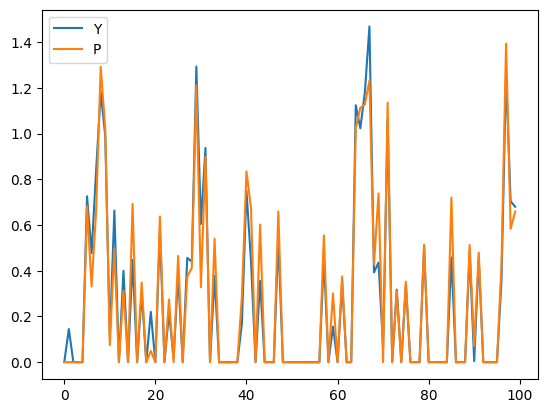

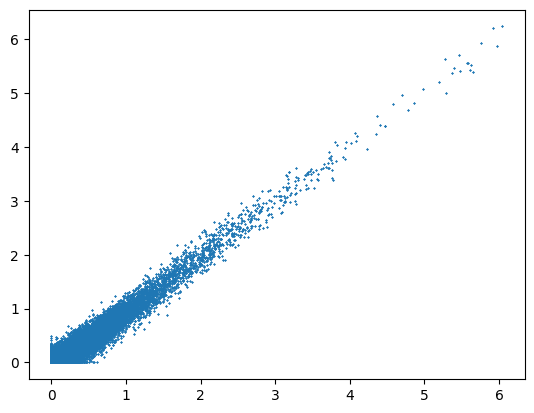

In [147]:
P_reg = reg(X_reg).detach()

@typed
def explore_dim(dim: int) -> None:
    k = 10**2
    plt.plot(Y_reg[:k, dim], label="Y")
    plt.plot(P_reg[:k, dim], label="P")
    plt.legend()
    plt.show()
    plt.plot(P_reg[:, dim], Y_reg[:, dim], "x", ms=1)
    plt.show()

explore_dim(6)

In [148]:
from sklearn.metrics import r2_score

for i_prefix in std_argsort:
    y = Y_reg[:, i_prefix]
    p = P_reg[:, i_prefix]
    c = reg[0].weight.detach()[i_prefix]
    c[:500] *= ((-1) ** np.arange(500))
    print(ls(i_prefix), ls(stds[i_prefix]), ls(r2_score(y, p)), sep="\t", end="\t")
    if (c == 0).all() or True:
        print()
    else:
        print(ls(c[c != 0].min()), ls(c[c != 0].max()), ls(c[c != 0].mean()), ls(c[c != 0].std()), sep="\t")

11	6.20	1.00	
41	5.34	1.00	
60	3.94	1.00	
24	1.81	0.99	
33	1.78	0.99	
31	1.76	1.00	
29	1.72	1.00	
7	1.66	0.97	
32	1.58	0.99	
45	1.58	1.00	
0	1.55	0.99	
42	1.50	1.00	
38	1.45	0.99	
52	1.45	0.99	
40	1.43	1.00	
50	1.41	0.99	
39	1.41	0.99	
62	1.40	1.00	
43	1.38	1.00	
54	1.38	0.99	
49	1.22	0.99	
16	1.16	0.98	
5	1.07	0.99	
27	1.00	0.99	
25	0.89	0.99	
47	0.87	0.99	
57	0.82	0.99	
20	0.55	0.98	
28	0.53	0.99	
6	0.46	0.95	
36	0.44	0.98	
3	0.34	0.97	
61	0.24	0.96	
44	0.00	-0.54	
4	0.00	-6.30	
2	0.00	-16.32	
59	0.00	-9.84	
56	0.00	-22.52	
10	0.00	-73.30	
35	0.00	-753.32	
48	0.00	0.00	
51	0.00	0.00	
53	0.00	0.00	
55	0.00	0.00	
58	0.00	0.00	
63	0.00	0.00	
18	0.00	0.00	
1	0.00	0.00	
8	0.00	0.00	
9	0.00	0.00	
12	0.00	0.00	
13	0.00	0.00	
14	0.00	0.00	
15	0.00	0.00	
17	0.00	0.00	
46	0.00	0.00	
19	0.00	0.00	
21	0.00	0.00	
22	0.00	0.00	
23	0.00	0.00	
26	0.00	0.00	
30	0.00	0.00	
34	0.00	0.00	
37	0.00	0.00	


<1 <2 <3 <4 4> 3> 2> 1> <5 <7 <8 8> 7> 5>
11: [ 0.00 0.55 1.29 2.29 1.04 0.00 0.00 0.00 0.00 0.12 0.81 0.01 0.00 0.00 ]
41: [ 1.57 0.00 0.00 0.00 0.00 0.00 1.62 2.73 1.33 0.00 0.00 0.00 1.42 2.79 ]
60: [ 8.42 7.24 6.56 5.53 6.95 7.94 8.52 8.47 8.12 7.45 6.96 7.54 8.17 8.47 ]


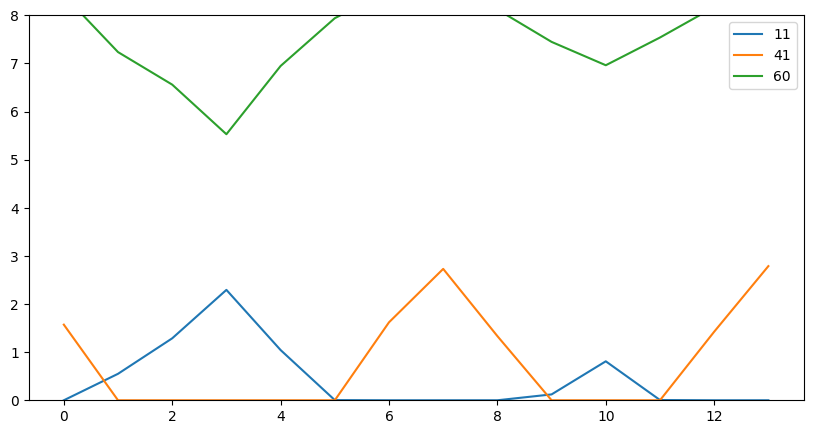

In [62]:
@typed
def explore_input(user_input: str, features: list[int]) -> None:
    if any(x >= len(tokenizer) - 2 for x in tokenizer.encode(user_input)):
        print("Invalid input. Please try again.")
    cur = compressed_activations(model, tokenizer, user_input, {layer: sae})[layer]
    plt.figure(figsize=(10, 5))
    plt.ylim(0, 8)
    print(user_input)
    for feature in features:
        normalized = cur[:, feature] / stds[feature]
        print(f"{feature}: {ls(normalized)}")
        plt.plot(normalized, label=feature)
    plt.legend()
    plt.show()

features = [11, 41, 60]
prompt = "<1 <2 <3 <4 4> 3> 2> 1> <5 <7 <8 8> 7> 5>"
explore_input(prompt, features)

In [ ]:
for x, y in pairs:
    print(x, y)

In [257]:
mid_l = 3
mid_r = 6
X_mid, Y_mid = input_output_mapping(
    model=model,
    tokenizer=tokenizer,
    prompts=get_prompts(10),
    input_layer=f"transformer.h.{mid_l}",
    output_layer=f"transformer.h.{mid_r - 1}",
)
Y_mid = (Y_mid - X_mid).reshape(-1, 256)
X_mid = X_mid.reshape(-1, 256)
mid_line = fit_linear(X_mid, Y_mid, reg="l2", alpha=1e-3)
print(
    eval_module(
        mid_line,
        X_mid,
        Y_mid,
    )
)

0.18959206342697144


In [320]:
standard_ln = nn.LayerNorm(256, elementwise_affine=False)

X_mlp_1, Y_mlp_1 = input_output_mapping(
    model=model,
    tokenizer=tokenizer,
    prompts=get_prompts(10),
    input_layer=f"transformer.h.1.ln_2",
    output_layer=f"transformer.h.1.mlp",
)
Y_mlp_1 = Y_mlp_1.reshape(-1, 256)
X_mlp_1 = standard_ln(X_mlp_1).reshape(-1, 256)
mlp_1 = fit_linear(X_mlp_1, Y_mlp_1, reg="l2", alpha=1e-3)


X_mlp_6, Y_mlp_6 = input_output_mapping(
    model=model,
    tokenizer=tokenizer,
    prompts=get_prompts(10),
    input_layer=f"transformer.h.6.ln_2",
    output_layer=f"transformer.h.6.mlp",
)
Y_mlp_6 = Y_mlp_6.reshape(-1, 256)
X_mlp_6 = standard_ln(X_mlp_6).reshape(-1, 256)
mlp_6 = fit_linear(X_mlp_6, Y_mlp_6, reg="l2", alpha=1e-3)

In [149]:
X_attn, Y_attn = input_output_mapping(
    model=model,
    tokenizer=tokenizer,
    prompts=get_prompts(10),
    input_layer="transformer.h.0",
    output_layer="transformer.h.0.attn",
)

X_attn_sums = X_attn.cumsum(dim=-2)
X_attn_lens = t.arange(1, X_attn_sums.size(-2) + 1).reshape(1, -1, 1)
Y_attn = Y_attn.reshape(-1, 256)
X_attn = (X_attn_sums / X_attn_lens).reshape(-1, 256)

attn_line = fit_linear(X_attn, Y_attn, reg="l2", alpha=1e-3)
print(
    eval_module(
        attn_line,
        X_attn,
        Y_attn,
    )
)

0.001996031031012535


In [127]:
X_wo_ln, Y_wo_ln = input_output_mapping(
    model=model,
    tokenizer=tokenizer,
    prompts=get_prompts(10),
    input_layer="transformer.h.0.ln_2",
    output_layer="transformer.h.0.mlp",
)
Y_wo_ln = Y_wo_ln.reshape(-1, 256)
X_wo_ln = standard_ln(X_wo_ln).reshape(-1, 256)
wo_ln = fit_linear(X_wo_ln, Y_wo_ln, reg="l2", alpha=1e-3)
print(eval_module(wo_ln, X_wo_ln, Y_wo_ln))

0.09023763239383698


In [362]:
from utils import prompt_from_template, get_loss, PrefixMean, Residual, Wrapper
from transformers import GPTNeoForCausalLM

new_model = AutoModelForCausalLM.from_pretrained("Mlxa/brackets-nested")
new_model.config.use_cache = False
new_model.config.output_attentions = False

new_model.transformer.h[0] = Wrapper(
    nn.Sequential(
        Residual(
            nn.Sequential(
                PrefixMean(),
                attn_line,
            )
        ),
        Residual(
            nn.Sequential(
                nn.LayerNorm(256, elementwise_affine=False),
                wo_ln,
            )
        ),
    ),
    append=(),
)

# new_model.transformer.h[6].ln_2 = nn.LayerNorm(256, elementwise_affine=False)
# new_model.transformer.h[6].mlp = mlp_6

new_model.transformer.h = nn.ModuleList(
    new_model.transformer.h[:mid_l]
    + [Wrapper(Residual(mid_line), append=())]
    + new_model.transformer.h[mid_r:]
)

prompt = prompt_from_template("((((((())))))()" * 3, random=True)
a = get_loss(model, tokenizer, prompt)
b = get_loss(new_model, tokenizer, prompt)
print(f"clean: {a:.3f}, corrupted: {b:.3f}")
print(f"delta: {b - a:.3f}")

clean: 3.649, corrupted: 3.735
delta: 0.085


In [363]:
new_model

GPTNeoForCausalLM(
  (transformer): GPTNeoModel(
    (wte): Embedding(502, 256)
    (wpe): Embedding(2048, 256)
    (drop): Dropout(p=0.0, inplace=False)
    (h): ModuleList(
      (0): Wrapper(
        (fn): Sequential(
          (0): Residual(
            (fn): Sequential(
              (0): PrefixMean()
              (1): Linear(in_features=256, out_features=256, bias=True)
            )
          )
          (1): Residual(
            (fn): Sequential(
              (0): LayerNorm((256,), eps=1e-05, elementwise_affine=False)
              (1): Linear(in_features=256, out_features=256, bias=True)
            )
          )
        )
      )
      (1-2): 2 x GPTNeoBlock(
        (ln_1): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
        (attn): GPTNeoAttention(
          (attention): GPTNeoSelfAttention(
            (attn_dropout): Dropout(p=0.0, inplace=False)
            (resid_dropout): Dropout(p=0.0, inplace=False)
            (k_proj): Linear(in_features=256, out_featu